In [12]:
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Activation, Dropout
from keras.optimizers import SGD
from keras.models import Model, Sequential
import keras
import tensorflow as tf
import keras.backend as K
import numpy as np
import os
import sys

In [13]:
from main import SGDL

In [14]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (50000, 32, 32, 3)
y_train original shape (50000, 1)


In [15]:
class SGDL(SGD):
    """Stochastic gradient descent Langevian optimizer.

    Includes support for momentum,
    learning rate decay, and Nesterov momentum.

    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter that accelerates SGD
            in the relevant direction and dampens oscillations.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.001, gamma=0.1, **kwargs):
        super(SGDL, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.gamma = K.variable(0.1, name="gamma")
        print(K.int_shape(self.iterations))

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        gamma = self.gamma * (1. / (1. + K.cast(self.iterations, tf.float32)))

        # momentum
        shapes = [K.int_shape(p) for p in params]
        gaussians = [K.random_normal(shape) for shape in shapes]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m, W in zip(params, grads, moments, gaussians):
            v = self.momentum * m - lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - lr * g
            else:
                new_p = p + v
            new_p = new_p + gamma * W

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

In [ ]:
def build_model():
#     inp = Input(shape=(28, 28))
#     x = inp
# #     x = Lambda(lambda x: K.expand_dims(x, -1))(x)
# #     x = Conv2D(32, (5, 5), activation='relu')(x)
# #     x = Conv2D(32, (3, 3), activation='relu')(x)
# #     x = Conv2D(32, (3, 3), activation='relu')(x)
#     x = Flatten()(x)
#     x = Dense(100, activation='relu')(x)
#     x = Dense(100, activation='relu')(x)
#     x = Dense(100, activation='relu')(x)
#     x = Dense(10, activation='softmax')(x)
#     model = Model(inputs=inp, outputs=x)

    model = Sequential()
    model.add(Flatten())
    model.add(Lambda(lambda x: x / 255.))
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                                  # of the layer above. Here, with a "rectified linear unit",
                                  # we clamp all values below 0 to 0.

    model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                     # ensures the output is a valid probaility distribution, that is
                                     # that its values are all non-negative and sum to 1.
    return model

In [ ]:
os.makedirs('logs', exist_ok=True)

model = {}
for gamma in [0, 0.1, 0.01, 0.001, 0.0001]:
    cb = keras.callbacks.CSVLogger(f'logs/SGDL_{gamma}.txt', separator=',')
    model[gamma] = build_model()
    model[gamma].compile(optimizer=SGDL(gamma=gamma), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model[gamma].fit(X_train, y_train,
              batch_size=32, epochs=10,
              verbose=1,
              validation_data=(X_test, y_test))

In [51]:
w = [[], [], []]
for i, e in enumerate([0.1, 0.01, 0.001]):
    w[i] = model[e].get_weights()
    
test_model = build_model()
test_model.compile(optimizer=SGDL(gamma=gamma), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
def get_loss(l0, l1, l2):
    new_weights = [l0*normal_w[0][i] + l1*normal_w[1][i]+l2*normal_w[2][i] for i in range(len(w[1]))]
    
    test_model.set_weights(new_weights)
    loss = test_model.evaluate(X_test, y_test)
    return loss

()


In [52]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

10000/10000 [==============================] - 1s 103us/step


10000/10000 [==============================] - 1s 111us/step


10000/10000 [==============================] - 1s 103us/step


10000/10000 [==============================] - 1s 105us/step


10000/10000 [==============================] - 1s 117us/step


10000/10000 [==============================] - 1s 81us/step


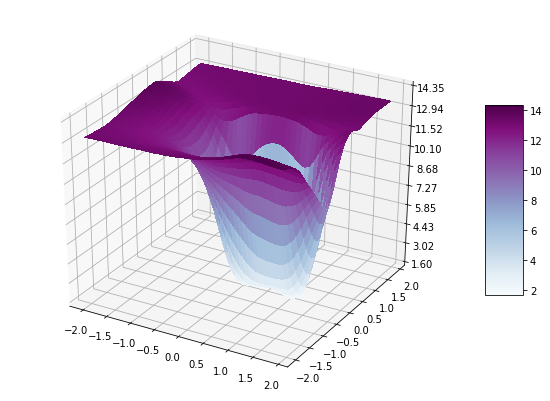

In [54]:
X = np.arange(-2, 2, .1)
Y = np.arange(-2, 2, .1)
X, Y = np.meshgrid(X, Y)
Z = np.array([[get_loss(X[i][j], Y[i][j], 1-X[i][j]-Y[i][j])[0] for j in range(len(X))] for i in range(len(X))])

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='BuPu',
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

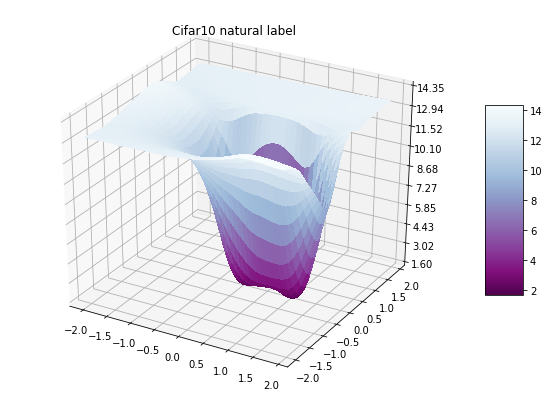

In [56]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='BuPu_r',
                       linewidth=0, antialiased=False)

plt.title("Cifar10 natural label")
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [25]:
X_norm, Y_norm, Z_norm = X, Y, Z

In [26]:
normal_w = w.copy()

In [27]:
y_train_rand = np.random.randint(0, 10, size=len(y_train)).reshape(len(y_train), 1)
y_test_rand = np.random.randint(0, 10, size=len(y_test)).reshape(len(y_test), 1)

In [ ]:
model_rand = {}
for gamma in [0.1, 0.01, 0.001]:
    cb = keras.callbacks.CSVLogger(f'logs/SGDL_{gamma}.txt', separator=',')
    model_rand[gamma] = build_model()
    model_rand[gamma].compile(optimizer=SGDL(gamma=gamma), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_rand[gamma].fit(X_test, y_test_rand,
              batch_size=32, epochs=10,
              verbose=1,
              validation_data=(X_test, y_test_rand))

In [39]:
for i, e in enumerate([0.1, 0.01, 0.001]):
    w[i] = model_rand[e].get_weights()

In [40]:
def get_loss(l0, l1, l2):
    new_weights = [l0*w[0][i] + l1*w[1][i]+l2*w[2][i] for i in range(len(w[1]))]
    
    test_model.set_weights(new_weights)
    loss = test_model.evaluate(X_test, y_test_rand)
    return loss

10000/10000 [==============================] - 1s 129us/step


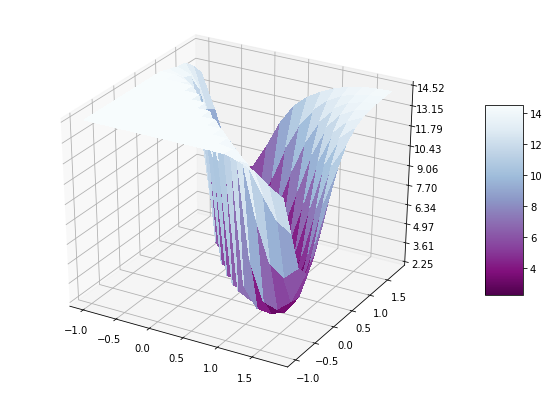

In [47]:
X = np.arange(-1, 2, .2)
Y = np.arange(-1, 2, .2)
X, Y = np.meshgrid(X, Y)
Z = np.array([[get_loss(X[i][j], Y[i][j], 1-X[i][j]-Y[i][j])[0] for j in range(len(X))] for i in range(len(X))])

fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='BuPu_r',
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

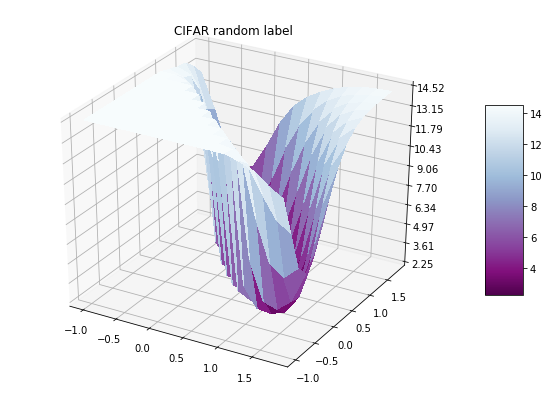

In [50]:
fig = plt.figure(figsize=(10,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='BuPu_r',
                       linewidth=0, antialiased=False)

plt.title("CIFAR random label")
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()